### ECG Transformation Across Varying Heart Rates

In [1]:
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer

import rlign

In [2]:
normalizer = rlign.Rlign(scale_method="linear")
hrc_normalizer = rlign.Rlign(scale_method='hrc')
template_ = rlign.Template(template_bpm=60)
normalizer.update_configuration(template=template_)
hrc_normalizer.update_configuration(template=template_)

In [3]:
#ecg40 = np.expand_dims(nk.ecg_simulate(sampling_rate=500, heart_rate=40), (0, 1)).repeat(12, axis=1)
#ecg80 = np.expand_dims(nk.ecg_simulate(sampling_rate=500, heart_rate=80), (0, 1)).repeat(12, axis=1)
data = np.load("demo_ecgs.npz")
ecg40 = data["X40"]
ecg80 = data["X80"]
# standard ecg form: (sample x lead x time)
ecg40.shape

(1, 12, 5000)

(500.0, 1500.0)

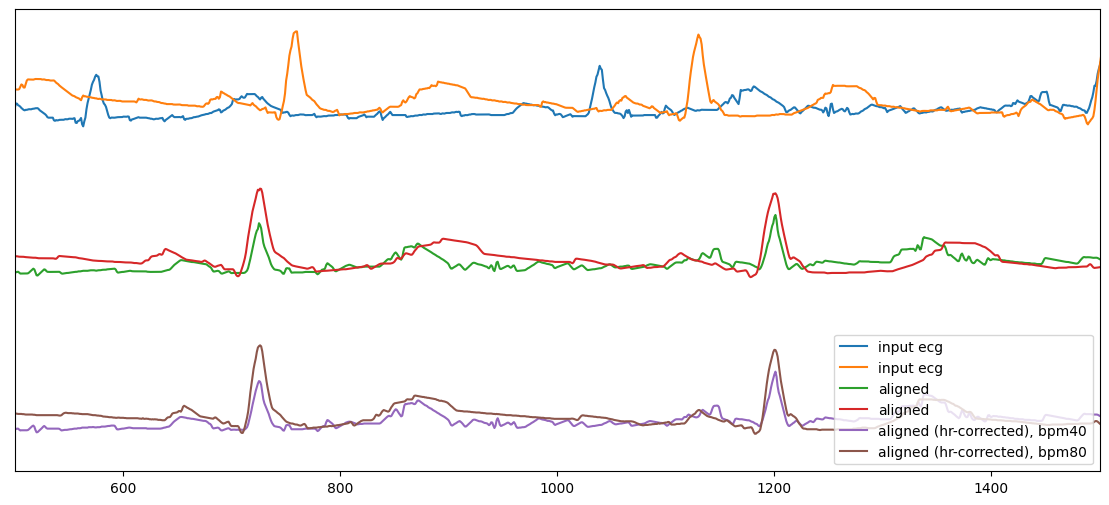

In [4]:
plt.figure(figsize=(14, 6))
channel = 1
plt.plot(ecg40[0].transpose(1,0)[:, channel], label="input ecg")
plt.plot(ecg80[0].transpose(1,0)[:, channel], label="input ecg")

ret40 = normalizer.transform(ecg40)
ret80 = normalizer.transform(ecg80)
ret2_40 = hrc_normalizer.transform(ecg40)
ret2_80 = hrc_normalizer.transform(ecg80)
plt.plot(ret40[0, channel, :] - 1.5, label="aligned")
plt.plot(ret80[0, channel, :] - 1.5, label="aligned")
plt.plot(ret2_40[0, channel, :] - 3, label="aligned (hr-corrected), bpm40")
plt.plot(ret2_80[0, channel, :] - 3, label="aligned (hr-corrected), bpm80")
plt.yticks([])
plt.legend(loc="lower right")
plt.xlim([500, 1500])

# Scikit-Learn-based Classification

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from pyts.multivariate.transformation import MultivariateTransformer

normal_ecgs = []
for i in range(30):
    normal_ecgs.append(nk.ecg_simulate(sampling_rate=500, 
                                       heart_rate=np.random.randint(40, 70)
                                       ).reshape((1,1,5000))
                       )
normal_ecgs = np.concatenate(normal_ecgs, axis=0)  
abnormal_ecgs = []
for i in range(30):
    abnormal_ecgs.append(1.1*nk.ecg_simulate(sampling_rate=500, 
                                             heart_rate=np.random.randint(40, 70)
                                             ).reshape((1,1,5000))
                         )
abnormal_ecgs = np.concatenate(abnormal_ecgs, axis=0)

In [6]:
X = np.concatenate([normal_ecgs, abnormal_ecgs], axis=0)
y = [0] * len(normal_ecgs) + [1] * len(abnormal_ecgs)

In [7]:
normalizer = rlign.Rlign(select_lead=0, scale_method="hrc")
template_ = rlign.Template(template_bpm=40)
normalizer.update_configuration(template=template_)

In [8]:
pipe = Pipeline([("Aligner", normalizer),
                 ("Eliminate-Multivaration", MultivariateTransformer(estimator=FunctionTransformer(), flatten=True)),
                 ("LR", LogisticRegression(max_iter=1000))])

In [9]:
%%time

print(f"Balanced accuracy on non-aligned ECGs: {round(np.mean(cross_val_score(LogisticRegression(), X[:, 0], y)), 3)}")
print(f"Balanced accuracy on aligned ECGs: {round(np.mean(cross_val_score(pipe, X, y)), 3)}")

Balanced accuracy on non-aligned ECGs: 0.517
Balanced accuracy on aligned ECGs: 0.95
CPU times: user 4.83 s, sys: 998 ms, total: 5.83 s
Wall time: 22.9 s


In [10]:
%%time

pipe = Pipeline([("Eliminate-Multivaration", 
                  MultivariateTransformer(estimator=FunctionTransformer(), flatten=True)),
                 ("LR", LogisticRegression(max_iter=1000))])

print(f"Balanced accuracy on non-aligned ECGs: {round(np.mean(cross_val_score(LogisticRegression(), X[:, 0], y)), 3)}")
Xt = normalizer.transform(X)
print(f"Balanced accuracy on aligned ECGs: {round(np.mean(cross_val_score(pipe, Xt, y)), 3)}")

Balanced accuracy on non-aligned ECGs: 0.517
Balanced accuracy on aligned ECGs: 0.95
CPU times: user 7.46 s, sys: 1.34 s, total: 8.8 s
Wall time: 3.85 s
